In [1]:
%matplotlib notebook
import sys
import numpy as np
from base_functions import *
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

#from matplotlib import rc
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
#rc('text', usetex=True)

># Analysis Code for the Edge Illumination Method:   

En las siguientes líneas de código se encuentran los recursos necesarios para leer los archivos .raw y así obtener los archivos .txt. En la segunda parte de este código se encuentra el análisis estadístico asociado a las imágenes anteriormente interpretadas, con la inclusión de la normalización mediante un _Flat Field_ y el posterior análisis de la recuperación de fase.

> **Código para lectura de los Raw:**

Esta primera sección abarca los códigos empleados para la lectura de los archivos .raw. Cada archivo se asume ha sido almacenado con el prefijo "Frame", para simplificar los procesos.

In [2]:
Pixels = 256 # Cantidad de Píxeles del Detector.
N_Raws = 4 # Cantidad de imágenes a analizar (ingresar un valor >= 2).
N_Dopple = 3 # El archivo .raw genera dos imágenes, este número indica eso para promediarlas.
path_raw = "raw\\" # Directorio donde están los Raw.
path_txt = "txt\\" # Directorio donde se ponen los Txt.

In [3]:
prefix = "D"

In [4]:
brute_material = Data_Import(path_raw, prefix, Pixels, N_Raws)
images = Image_Generator(brute_material, N_Raws, N_Dopple)
for i in range(1, N_Raws + 1):
    try:
        np.savetxt(path_txt + "{}{}.txt".format(prefix, i), images[i - 1])
    except IndexError:
        # np.savetxt(path_txt + "{}.txt".format(Name_Used), images[0])
        break
        
if len(brute_material) > N_Raws:
    np.savetxt(path_txt + "{}_FF.txt".format(prefix), images[N_Raws])

131072
131072
131072
131072
131072
131072
131072
131072


> **Visualización previa:**

A continuación se puede observar el mapa de intensidades asociado a la imagen $k$-ésima de la lista images. Si el conjunto de imágenes incluye el Flat Field, se debe de colocar el valor de $k$ igual a $-1$ (último item de la lista). El mapa mostrado **no está normalizado**.

<IPython.core.display.Javascript object>


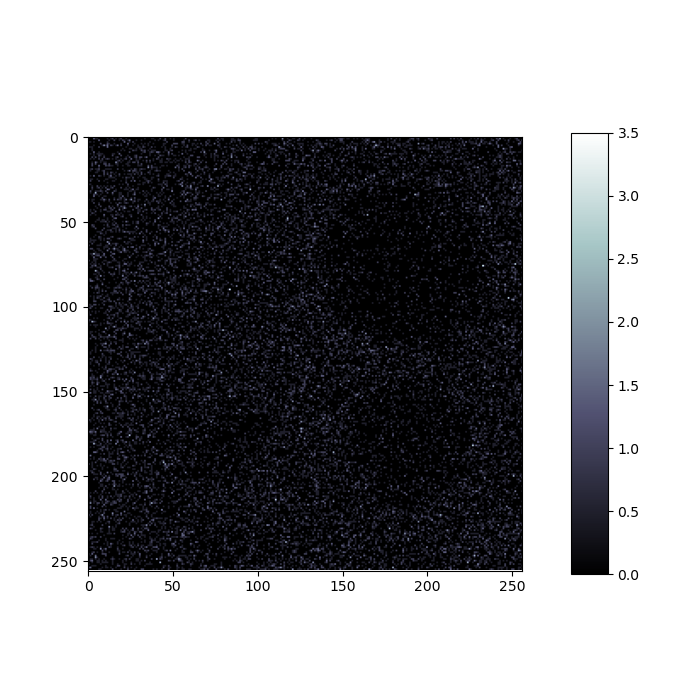

In [5]:
k = 2
fig, ax = plt.subplots(figsize=(7, 7))
map_ = ax.imshow(images[k], cmap = "bone")
fig.colorbar(map_, ax =ax , location='right', anchor=(0.5, 0.5), shrink=0.82, aspect=12)

En este apartado se logra apreciar la curva asociada a las intensidades de cada columna de píxeles, estando estos valores normalizados.

<IPython.core.display.Javascript object>


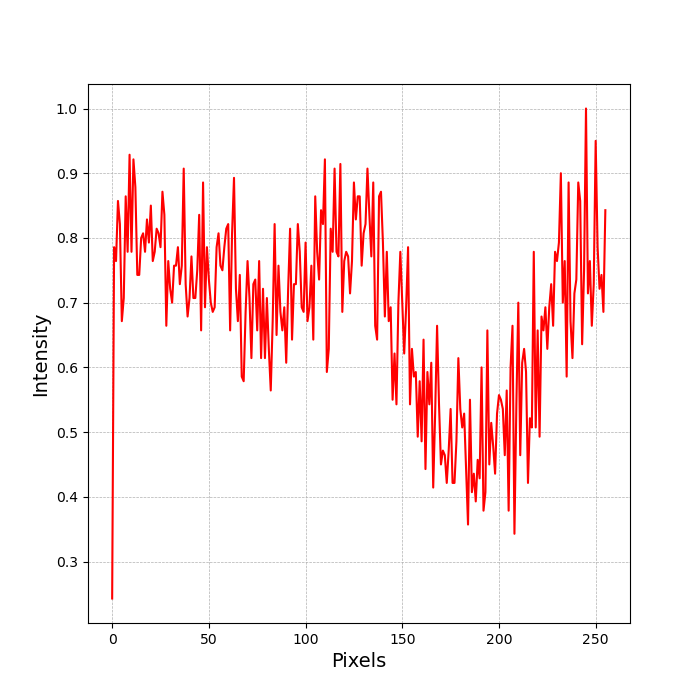

In [6]:
fig, ax = plt.subplots(figsize=(7, 7))
intensities = Intensity_Mean(images[k], Pixels)
ax.plot(intensities, '-', color="red")
ax.set_xlabel("Pixels", fontsize = 14)
ax.set_ylabel("Intensity", fontsize = 14)
ax.grid(linestyle = '--', linewidth = 0.5)

> **Histograma de Intensidades:**

Este histograma permite conocer la distribución de intensidades entre los píxeles pares e impares. Para poder determinar qué tan óptimo es el step seleccionado, ambos histogramas deben estár lo más superpuestos posible.

<IPython.core.display.Javascript object>


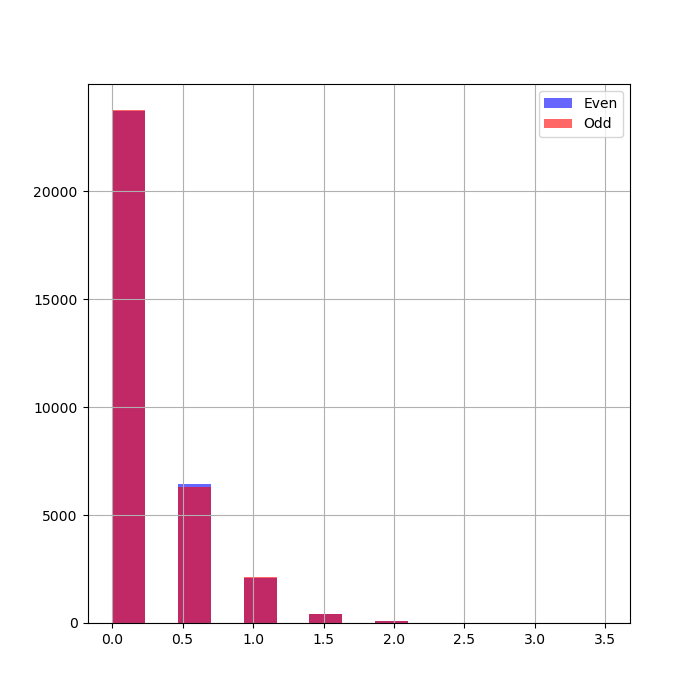

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.grid(True)

even_pixels = images[k][:,::2]
odd_pixels = images[k][:,1::2]
even_ = np.ravel(even_pixels)
odd_ = np.ravel(odd_pixels)

bin_size = 15
GNMe =ax.hist(even_, bins = bin_size, color="blue", label="Even", alpha=0.6)
GNMo =ax.hist(odd_, bins = bin_size, color="red", label="Odd", alpha=0.6)
# ax.set_title("Step {}".format(), fontsize=16)
ax.legend()

> **Normalización:**

Una vez leídos y guardados los archivos .raw, se reescriben de forma tal que los valores se encuentren normalizados en función del Flat Field recolectado.

In [8]:
for i in range(1, N_Raws + 1):
    try:
        Frame = np.loadtxt(path_txt + "{}{}.txt".format(prefix, i))  # Carga las imágenes tomadas.
        FrameFF = 1  # Carga la imagen del Flat Field.
    except Exception as e:
        print(f"Error al cargar los archivos: {e}")
        sys.exit()

    # Realizar la división evitando división por cero
    N_Frame = np.divide(Frame, FrameFF, out = np.zeros_like(Frame), where = FrameFF != 0)
    np.savetxt(path_txt + "Norm\\Frame_{}.txt".format(i), N_Frame, fmt = "%.6f")  

> **Código para la suma de las imágenes:**

In [9]:
z_FS = 0.6 # Distancia Fuente - Objeto
z_SD = 1.2 # Distancia Objeto - Detector
z_FD = z_FS + z_SD # Distancia Fuente - Detector
M = z_FD/z_FS # Magnificación
E_J = 20 #keV
h=6.63*10**(-34)
c=3*(10**(8))
k=(2*np.pi*E_J)/(h*c)
o = k/z_SD

# Todos estos parámetros están aún por ser determinados en su significado.
a =  31.6*(10**(-6)) # Tamaño de apertura de la máscara.

In [10]:
txt_images = []
for i in range(1, N_Raws + 1):
    image = np.genfromtxt(path_txt + "{}{}.txt".format(prefix, i))
    txt_images.append(image)

In [11]:
Odd_Maps = []
Even_Maps =[]
Absor_Maps = []
Phase_Maps = []

for i in range(0, N_Raws): 
    odd = txt_images[i][:,1::2] 
    even = txt_images[i][:,::2]
    
    absor = (txt_images[i][:,::2] + txt_images[i][:,1::2])/2
    p_num = txt_images[i][:,1::2] - txt_images[i][:,::2]
    d_num = txt_images[i][:,1::2] + txt_images[i][:,::2]
    phase = (M*a*o/2)*np.divide(p_num, d_num, out = np.ones_like(p_num), where = d_num != 0)

    
    Odd_Maps.append(odd)
    Even_Maps.append(even)
    Absor_Maps.append(absor)
    Phase_Maps.append(phase)

In [12]:
Sep = int(Pixels/2)
Odd_Dith = np.zeros((Pixels, N_Raws*Sep))
Even_Dith = np.zeros((Pixels, N_Raws*Sep))
Absor_Dith = np.zeros((Pixels, N_Raws*Sep))
Phase_Dith = np.zeros((Pixels, N_Raws*Sep))

print(Odd_Dith.shape)

for i in range(0, N_Raws):
    for j in range(0, int(Pixels/2)):
        Odd_Dith[:, N_Raws*j + i:N_Raws*j + i + 1] = Odd_Maps[N_Raws - 1 - i][:,j:j + 1]
        Even_Dith[:, N_Raws*j + i:N_Raws*j + i + 1] = Even_Maps[N_Raws - 1 - i][:,j:j + 1]
        Absor_Dith[:, N_Raws*j + i:N_Raws*j + i + 1] = Absor_Maps[N_Raws - 1 - i][:,j:j + 1]
        Phase_Dith[:, N_Raws*j + i:N_Raws*j + i + 1] = Phase_Maps[N_Raws - 1 - i][:,j:j + 1]

Factor = Odd_Dith.shape[0]/Odd_Dith.shape[1]

Odd = zoom(Odd_Dith, (1, Factor))
Even = zoom(Even_Dith, (1, Factor))
Absor= zoom(Absor_Dith, (1, Factor))
Phase = zoom(Phase_Dith, (1, Factor))

Total = (Even + Odd)/np.max(Even + Odd)

print(Odd.shape)

I_Absor = Intensity_Mean(Absor, Absor.shape[0])
I_Phase = Intensity_Mean(Phase, Phase.shape[0])
I_Total = Intensity_Mean(Total, Total.shape[0])


(256, 512)
(256, 256)


<IPython.core.display.Javascript object>


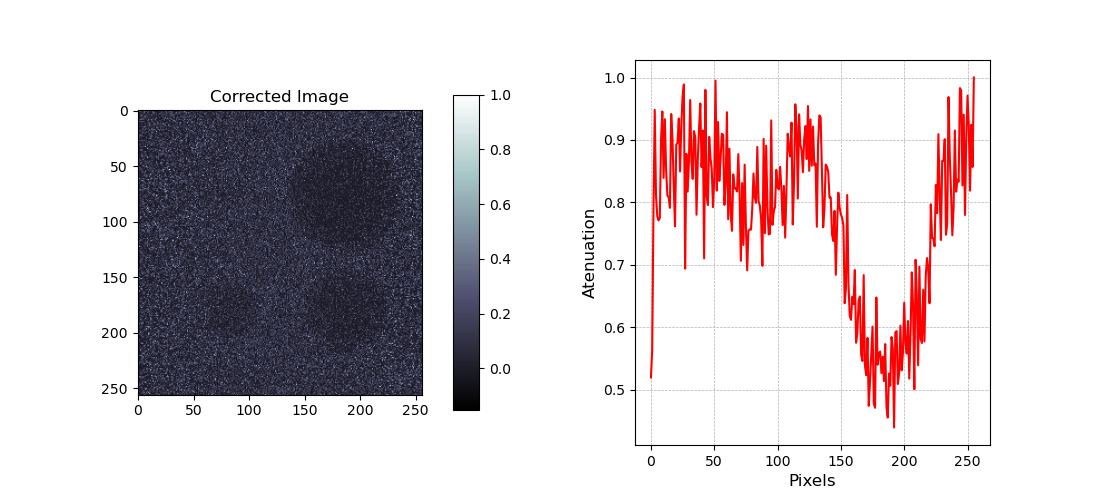

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
plt.subplots_adjust(wspace = 0.4)

ax[0].set_title("Corrected Image")
im = ax[0].imshow(Total, cmap="bone")
fig.colorbar(im, ax = ax[0], location = 'right', anchor = (0.5, 0.5), shrink = 0.82, aspect = 12)

ax[1].plot(I_Total, '-', color = "red")
ax[1].set_xlabel("Pixels", fontsize = 12)
ax[1].set_ylabel("Atenuation", fontsize = 12)
ax[1].grid(linestyle = '--', linewidth = 0.5)

<IPython.core.display.Javascript object>


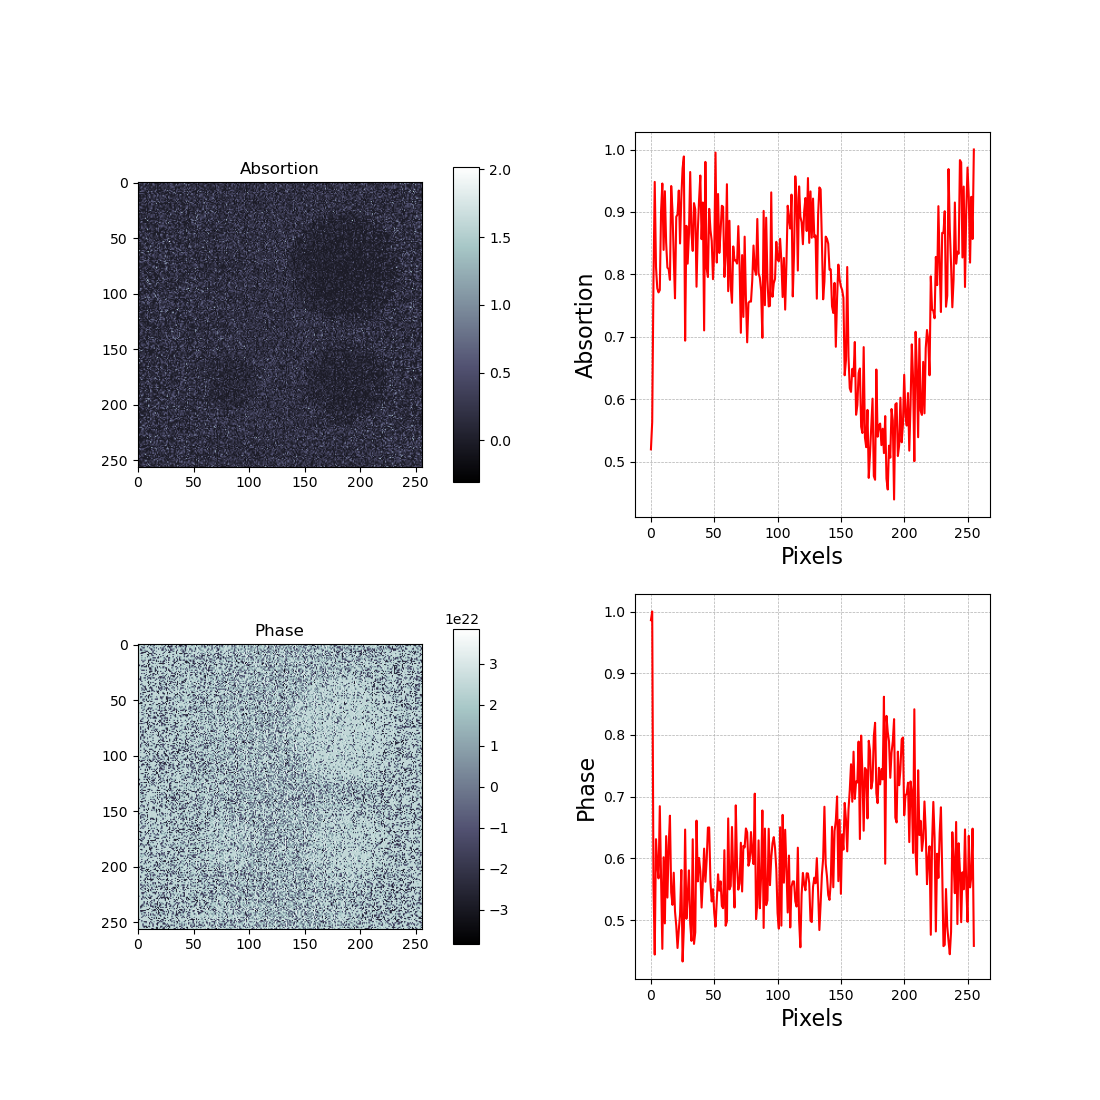

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(11, 11))
plt.subplots_adjust(wspace = 0.4)

ax[0, 0].set_title("Absortion")
im = ax[0, 0].imshow(Absor, cmap="bone")
fig.colorbar(im, ax = ax[0, 0], location = 'right', anchor=(0.5, 0.5), shrink = 0.82, aspect = 12)

ax[1, 0].set_title("Phase")
im_ = ax[1, 0].imshow(Phase, cmap="bone")
fig.colorbar(im_, ax = ax[1, 0], location = 'right', anchor=(0.5, 0.5), shrink = 0.82, aspect = 12)

ax[0, 1].plot(I_Absor, '-', color = "red")
ax[0, 1].set_xlabel("Pixels", fontsize = 16)
ax[0, 1].set_ylabel("Absortion", fontsize = 16)
ax[0, 1].grid(linestyle = '--', linewidth = 0.5)

ax[1, 1].plot(I_Phase, '-', color = "red")
ax[1, 1].set_xlabel("Pixels", fontsize = 16)
ax[1, 1].set_ylabel("Phase", fontsize = 16)
ax[1, 1].grid(linestyle = '--', linewidth = 0.5)

In [15]:
# SNR y CNR para la región de interes (ROI)

#BGx_bounds es una lista de un rango x_min a x_max donde se encuentre una sección del fondo (BackGound) (BG)
#BGx_bounds es una lista de un rango y_min a y_max donde se encuentre una sección del fondo (BackGound) (BG)

BGx_bounds, BGy_bounds = [0, 55], [0,256]


#ROIx_bounds es una lista de listas de un rango x_min a x_max donde se encuentra el ROI correspondiente
#ROIy_bounds es una lista de listas de un rango y_min a y_max donde se encuentra el ROI correspondiente

ROIx_bounds, ROIy_bounds = [[145,215], [60,105], [150,205]], [[0,33], [155,190], [150,200]]

def SNR(image, ROI_num, ROIx_bounds, ROIy_bounds, BGx_bounds, BGy_bounds):

    SNR_ROIs = []

    roi_bg = image[BGy_bounds[0]:BGy_bounds[1], BGx_bounds[0]:BGx_bounds[1]]
    mean_bg = np.mean(roi_bg)
    std_bg = np.std(roi_bg)

    for i in range(ROI_num):

        roi = image[ROIy_bounds[i][0]:ROIy_bounds[i][1],
                          ROIx_bounds[i][0]:ROIx_bounds[i][1]]
        mean_roi = np.mean(roi)

        snr = np.abs(mean_roi - mean_bg) / std_bg
        SNR_ROIs.append(snr)
    
    return SNR_ROIs

def CNR(image, ROI_num, ROIx_bounds, ROIy_bounds, BGx_bounds, BGy_bounds):

    CNR_ROIs = []

    roi_bg = image[BGy_bounds[0]:BGy_bounds[1], BGx_bounds[0]:BGx_bounds[1]]
    mean_bg = np.mean(roi_bg)
    std_bg = np.std(roi_bg)

    for i in range(ROI_num):

        roi = image[ROIy_bounds[i][0]:ROIy_bounds[i][1],
                          ROIx_bounds[i][0]:ROIx_bounds[i][1]]
        mean_roi = np.mean(roi)
        std_roi = np.std(roi)

        cnr = np.abs(mean_roi - mean_bg) / np.sqrt(std_roi**2 + std_bg**2)
        CNR_ROIs.append(cnr)
    
    return CNR_ROIs

In [16]:
CNR(Total, 3, ROIx_bounds, ROIy_bounds, BGx_bounds, BGy_bounds)

[0.02255790713958926, 0.18472116561358037, 0.3090176254556781]

In [17]:
SNR(Total, 3, ROIx_bounds, ROIy_bounds, BGx_bounds, BGy_bounds)

[0.030460014137290384, 0.23243466863839166, 0.37373643947905205]